# 🔍 Skill Damage Simulation Overview

This notebook analyzes and compares the skill damage output of three adventurers—**Gagarin**, **Leonardo**, and **Dragon Girl**—under simulated combat scenarios. Each simulation computes **damage per use** of individual skills as well as **cumulative damage over 10 rounds**, to provide insight into scaling behavior across skill levels and synergy effects.

## ⚙️ Assumptions and Base Parameters

The following assumptions were made to keep calculations consistent and comparable across characters and scenarios:

### 📌 Player Parameters (Constant for All)
These define the attacking character’s offensive strength is based on late game builds:

- **Base ATK** (`P_ATK`) = 10,000,000  
- **ATK % Bonus** (`P_ATK_pct`) = 3000%  
- **Global ATK % Bonus** (`P_Global_ATK_pct`) = 250%  

The **Final ATK value** used in all calculations is:


FINAL_ATK = P_ATK × Strength(1.1/1.15/1.2) × (1 + ATK%) × (1 + Global ATK%)
= 10,000,000 × 1.15 × (1 + 30) × (1 + 2.5)
= 1247750000.0

### 💀 Enemy Parameters

- **Enemy Max HP** = 3,500,000,000,000 (3.5 Trillion)  
- **Player Max HP** = 3,500,000,000  

These are used for conditional damage boosts (e.g., damage based on HP) and survivability modeling when applicable.

### 🗡️ Skill-Specific Assumptions

#### Dagger Bonus Damage:
Several skills rely on dagger mechanics. To simulate enhanced dagger output, the following flat multiplier is assumed:

- `dagger_bonus = 120`  
  - **Whisper Bow**: +35% dagger damage  
  - **Physical Damage Gems**: +85% dagger damage

As a whisper main, it is useful to see how much dagger damage is being done and the amount of damage being replaced with Gagarin's missile ability.

## 🧪 Scenarios

- **200% Skill Damage**: Lower end on skill damage
- **400% Skill Damage**: Higher end on skill damage

Seeing a 200% skill damage difference lets us compare adventures growth rate related to skill damage.

For **Dragon Girl**, an additional factor—**Stack count**—was evaluated:
- `"No Stacks"` = baseline form
- `"20 Stacks"` = fully ramped damage state

Having No stacks or stacks helps shows the upper and lower bound of Dragon Girls damage.

In [ ]:
import pandas as pd

# === 1. BASE STATS ===
BASE_PARAMS = dict(
    P_ATK=10_000_000,
    P_Strength=1.20,
    P_ATK_pct=3000,
    P_Global_ATK_pct=250,
)

TARGET_HP = 3_500_000_000_000

FINAL_ATK = (
    BASE_PARAMS["P_ATK"]
    * BASE_PARAMS["P_Strength"]
    * (1 + BASE_PARAMS["P_ATK_pct"] / 100)
    * (1 + BASE_PARAMS["P_Global_ATK_pct"] / 100)
)

# === 2. DAMAGE HELPERS ===
def hit_damage(coef, dagger_bonus, global_dagger_bonus, global_skill_bonus):
    return FINAL_ATK * coef * (1 + dagger_bonus / 100) * (1 + (global_dagger_bonus + global_skill_bonus) / 100)

def missile_mix_daggers(num_daggers, missile_chance, missile_coef, dagger_coef=0.45):
    return [(1 - missile_chance) * num_daggers * dagger_coef, missile_chance * num_daggers * missile_coef]

# === 3. GAGARIN DAMAGE MODEL ===
def gagarin_damage(level, dagger_bonus):
    missile_chance = 0.65 if level >= 5 else 0.50
    missile_coef = 1.00 if level >= 2 else 0.80
    global_dagger_bonus = 30 if level >= 10 else 0
    global_skill_bonus = 30 if level >= 10 else 0

    rage_atk = hit_damage(2.60, dagger_bonus, global_dagger_bonus, global_skill_bonus)
    total_daggers = 3 + (5 * 2 + 1)
    dagger_coef_total, missile_coef_total = missile_mix_daggers(total_daggers, missile_chance, missile_coef)
    daggers_dmg = hit_damage(dagger_coef_total, dagger_bonus, global_dagger_bonus, global_skill_bonus)
    missiles_dmg = hit_damage(missile_coef_total, dagger_bonus, global_dagger_bonus, global_skill_bonus)
    
    if level < 4:
        bomb = 0
    elif level >= 7:
        bomb = hit_damage(18.00, dagger_bonus, global_dagger_bonus, global_skill_bonus) + min(FINAL_ATK * 100, TARGET_HP * 0.1)
    else:
        bomb = hit_damage(9.00, dagger_bonus, global_dagger_bonus, global_skill_bonus)

    basic_atk = hit_damage(5.00, 0, 0, 0)
    total = rage_atk + daggers_dmg + missiles_dmg + bomb + basic_atk

    return {
        "RageATK": rage_atk,
        "Daggers": daggers_dmg,
        "Missiles": missiles_dmg,
        "BasicATK": basic_atk,
        "Bomb": bomb,
        "Total": total
    }

# === 4. COLLECT DATA ===
levels = [0, 2, 4, 5, 7, 10]
rounds = 10
skill_dmg_bonuses = [200, 400]
dagger_bonus = 120

skill_rows = []
round_rows = []

for skill_dmg_bonus in skill_dmg_bonuses:
    for lvl in levels:
        row = gagarin_damage(lvl, skill_dmg_bonus + dagger_bonus)
        row["Level"] = lvl
        row["Scenario"] = f"{skill_dmg_bonus}%"
        row["Source"] = "Gagarin"
        skill_rows.append(row)

        total = 0
        for rnd in range(1, rounds + 1):
            round_dmg = row["RageATK"] + row["Daggers"] + row["Missiles"] + row["BasicATK"]
            if rnd % 2 == 0:
                round_dmg += row["Bomb"]
            total += round_dmg
            round_rows.append({
                "Round": rnd,
                "Level": lvl,
                "Scenario": f"{skill_dmg_bonus}%",
                "Source": "Gagarin",
                "TotalDamage": total
            })

# === 5. FINAL DATAFRAMES ===
df_gaga_skill = pd.DataFrame(skill_rows)[[
    "Source", "Scenario", "Level", "RageATK", "Daggers", "Missiles", "BasicATK", "Bomb", "Total"
]]

df_gaga_rounds = pd.DataFrame(round_rows)[[
    "Source", "Scenario", "Level", "Round", "TotalDamage"
]]


In [ ]:
import pandas as pd

# === 1. BASE STATS ===
BASE_PARAMS = dict(
    P_ATK=10_000_000,
    P_Strength=1.10,
    P_ATK_pct=3000,
    P_Global_ATK_pct=250,
)

FINAL_ATK = (
    BASE_PARAMS["P_ATK"]
    * BASE_PARAMS["P_Strength"]
    * (1 + BASE_PARAMS["P_ATK_pct"] / 100)
    * (1 + BASE_PARAMS["P_Global_ATK_pct"] / 100)
)

TARGET_HP = 3_500_000_000_000

# === 2. DAMAGE HELPERS ===
def hit_damage(coef_pct, skill_bonus_pct=0.0, global_bonus_pct=0.0):
    return FINAL_ATK * (coef_pct / 100) * (1 + skill_bonus_pct / 100) * (1 + global_bonus_pct / 100)

# === 3. SKILL FUNCTIONS ===
def sbs_damage(level, skill_bonus, global_bonus):
    base_phys = sum(hit_damage(c, skill_bonus, global_bonus) for c in (30, 70, 100))
    if level >= 2:
        ninjutsu_chance = 1 - (1 - 0.7) ** 3  # probability of at least one proc across 3 hits
        extra_ninjutsu = ninjutsu_chance * hit_damage(100, skill_bonus, global_bonus)
    else:
        extra_ninjutsu = 0
    return base_phys + extra_ninjutsu

def hsd_damage(level, skill_bonus, global_bonus):
    if level < 4:
        return 0
    coef = 400 if level >= 7 else 200
    base = 5 * hit_damage(coef, skill_bonus, global_bonus)
    hp_dmg_cap = 20 * FINAL_ATK if level >= 7 else 0
    hp_dmg_val = 0.02 * TARGET_HP if level >= 7 else 0
    hp_dmg = 5 * min(hp_dmg_val, hp_dmg_cap)
    return base + hp_dmg

def hsd_cd(level):
    return 2 if level >= 7 else 3

def wts_damage(level, skill_bonus, global_bonus):
    if level < 8:
        return 0
    coef = 500 if level >= 10 else 300
    return 3 * hit_damage(coef, skill_bonus, global_bonus)

def rage_damage(level, scenario_pct, skill_bonus, global_bonus, phys_bonus=0):
    if level >= 8:
        return 0, 0
    rage_atk = hit_damage(260, skill_bonus, global_bonus)
    rage_dagger = 3 * hit_damage(45, skill_bonus + scenario_pct + phys_bonus, global_bonus)
    return rage_atk, rage_dagger

def total_dagger_damage(level, scenario_pct, skill_bonus, global_bonus, phys_bonus=0):
    return 11 * hit_damage(45, skill_bonus + scenario_pct + phys_bonus, global_bonus)

# === 4. SIMULATION LOOP ===
levels = [0, 2, 4, 5, 7, 8, 10]
scenarios = [200, 400]
dagger_damage = 120

skill_rows = []
round_rows = []

for scenario in scenarios:
    for lvl in levels:
        skill_bonus = scenario + 100 if lvl >= 5 else scenario
        global_bonus = 60 if lvl >= 10 else 0
        phys_bonus = 100 if lvl >= 5 else 0
        cooldown = hsd_cd(lvl)

        sbs = sbs_damage(lvl, skill_bonus, global_bonus)
        hsd = hsd_damage(lvl, skill_bonus, global_bonus)
        wts = wts_damage(lvl, skill_bonus, global_bonus)
        base_daggers = total_dagger_damage(lvl, dagger_damage, skill_bonus, global_bonus, phys_bonus)
        rage_atk, rage_dagger = rage_damage(lvl, dagger_damage, skill_bonus, global_bonus, phys_bonus)
        total_daggers = base_daggers + rage_dagger
        total = sbs * 5 + wts + total_daggers + rage_atk + hsd

        skill_rows.append(dict(
            Source="Leonardo",
            Scenario=f"{scenario}%",
            Level=lvl,
            SBS=sbs,
            HSD=hsd,
            WTS=wts,
            RageATK=rage_atk,
            Daggers=total_daggers,
            Total=total
        ))

        cum_dmg = 0
        for rnd in range(1, 11):
            dmg = sbs * 5 + wts + total_daggers + rage_atk
            if rnd % cooldown == 0:
                dmg += hsd
            cum_dmg += dmg
            round_rows.append(dict(
                Source="Leonardo",
                Scenario=f"{scenario}%",
                Level=lvl,
                Round=rnd,
                TotalDamage=cum_dmg
            ))

# === 5. FINAL DATAFRAMES ===
df_leo_skill = pd.DataFrame(skill_rows)[[
    "Source", "Scenario", "Level", "SBS", "HSD", "WTS", "RageATK", "Daggers", "Total"
]]

df_leo_rounds = pd.DataFrame(round_rows)[[
    "Source", "Scenario", "Level", "Round", "TotalDamage"
]]


In [ ]:
import pandas as pd

# === BASE STATS ===
BASE_PARAMS = dict(
    P_ATK=10_000_000,
    P_Strength=1.15,
    P_ATK_pct=3000,
    P_Global_ATK_pct=250,
)

FINAL_ATK = (
    BASE_PARAMS["P_ATK"]
    * BASE_PARAMS["P_Strength"]
    * (1 + BASE_PARAMS["P_ATK_pct"] / 100)
    * (1 + BASE_PARAMS["P_Global_ATK_pct"] / 100)
)

MAX_HP = 3_500_000_000
ENEMY_HP = 3_500_000_000_000

def hit_damage(coef_pct, flame_bonus_pct=0.0, final_dmg_pct=0.0):
    return FINAL_ATK * (coef_pct / 100) * (1 + flame_bonus_pct / 100) * (1 + final_dmg_pct / 100)

def dragon_breath(level, flame_bonus, global_bonus, with_stacks=False):
    coef = 180 if level >= 2 else 90
    final_bonus = global_bonus
    return hit_damage(coef, flame_bonus, final_bonus)

def rage_combo_damage_dg(level, flame_bonus, global_bonus, skill_bonus_pct=0.0, dagger_bonus_pct=120, with_stacks=False):
    rage_hit = hit_damage(260, 0, global_bonus)
    breath = dragon_breath(level, flame_bonus, global_bonus, with_stacks)
    daggers = 14 * hit_damage(45, 0, global_bonus + skill_bonus_pct + dagger_bonus_pct)
    return rage_hit, breath, daggers

def catastrophic_breath(level, flame_bonus, global_bonus, with_stacks=False):
    if level < 4:
        return 0
    coef = 1200 if level >= 7 else 600
    return hit_damage(coef, flame_bonus, global_bonus)

def dragons_wrath(level):
    if level < 8:
        return 0
    cap = 100 * FINAL_ATK
    dmg_self = min(0.10 * MAX_HP, cap)
    dmg_enemy = min(0.10 * ENEMY_HP, cap)
    return dmg_self + dmg_enemy

def compute_dragon_girl_dataframes(source_name, flame_skill_bonus_pct):
    levels = [0, 2, 4, 5, 7, 8, 10]
    rounds = list(range(1, 16))
    per_use_rows = []
    round_rows = []

    for lvl in levels:
        base_global_bonus = 30 if lvl >= 8 else 0

        # Calamity Dragon Breath global bonus
        if lvl >= 4:
            base_global_bonus += 60 if lvl >= 7 else 30

        for stacks in [False, True]:
            global_flame_bonus = base_global_bonus
            if stacks and lvl >= 5:
                global_flame_bonus += 100

            # Precompute all major damage sources
            flame_skill_bonus = flame_skill_bonus_pct
            basic_atk = hit_damage(100, 0, global_flame_bonus)
            breath = dragon_breath(lvl, flame_skill_bonus, global_flame_bonus, with_stacks=stacks)
            rage_atk, rage_breath, daggers = rage_combo_damage_dg(
                lvl, flame_skill_bonus, global_flame_bonus, flame_skill_bonus_pct, with_stacks=stacks)
            cata = catastrophic_breath(lvl, flame_skill_bonus, global_flame_bonus, with_stacks=stacks)
            wrath = dragons_wrath(lvl)

            # Total damage per use
            per_use_rows.append(dict(
                Source=source_name,
                Level=lvl,
                Scenario=f"{flame_skill_bonus_pct}%",
                Stacks="20 Stacks" if stacks else "No Stacks",
                BasicATK=5 * basic_atk,
                BasicBreath=5 * breath,
                RageATK=rage_atk,
                BreathFromRage=rage_breath,
                Daggers=daggers,
                Catastrophic=cata,
                DragonWrath=wrath,
                Total=(
                    5 * basic_atk + 5 * breath
                    + rage_atk + rage_breath + daggers
                    + cata + wrath
                )
            ))

            # === Total Damage Over Rounds ===
            total = 0
            for rnd in rounds:
                round_dmg = 0
                round_dmg += 5 * basic_atk
                round_dmg += 5 * breath
                round_dmg += rage_atk
                round_dmg += rage_breath
                round_dmg += daggers
                if lvl >= 4 and rnd % 2 == 1:
                    round_dmg += catastrophic_breath(lvl, flame_skill_bonus, global_flame_bonus, with_stacks=stacks)
                if lvl >= 8:
                    round_dmg += dragons_wrath(lvl)

                total += round_dmg
                round_rows.append(dict(
                    Source=source_name,
                    Level=lvl,
                    Scenario=f"{flame_skill_bonus_pct}%",
                    Stacks="20 Stacks" if stacks else "No Stacks",
                    Round=rnd,
                    TotalDamage=total
                ))
  
    df_use = pd.DataFrame(per_use_rows)
    df_rounds = pd.DataFrame(round_rows)
    return df_use, df_rounds

df_dg_200_use, df_dg_200_rounds = compute_dragon_girl_dataframes("Dragon Girl", 200)
df_dg_400_use, df_dg_400_rounds = compute_dragon_girl_dataframes("Dragon Girl", 400)

# Combine 200% and 400% skill usage data
df_dg_skill = pd.concat([df_dg_200_use, df_dg_400_use], ignore_index=True)[[
    "Source", "Scenario", "Stacks", "Level", 
    "RageATK", "Daggers", "Catastrophic", "DragonWrath", 
    "BasicATK", "BasicBreath", "BreathFromRage", "Total"
]]

# Combine 200% and 400% cumulative round data
df_dg_rounds = pd.concat([df_dg_200_rounds, df_dg_400_rounds], ignore_index=True)[[
    "Source", "Scenario", "Stacks", "Level", "Round", "TotalDamage"
]]


In [ ]:
# Combine all skill dataframes
df_all_skills = pd.concat([
    df_leo_skill,
    df_gaga_skill,
    df_dg_skill
], ignore_index=True)

# Combine all round dataframes
df_all_rounds = pd.concat([
    df_leo_rounds,
    df_gaga_rounds,
    df_dg_rounds
], ignore_index=True)


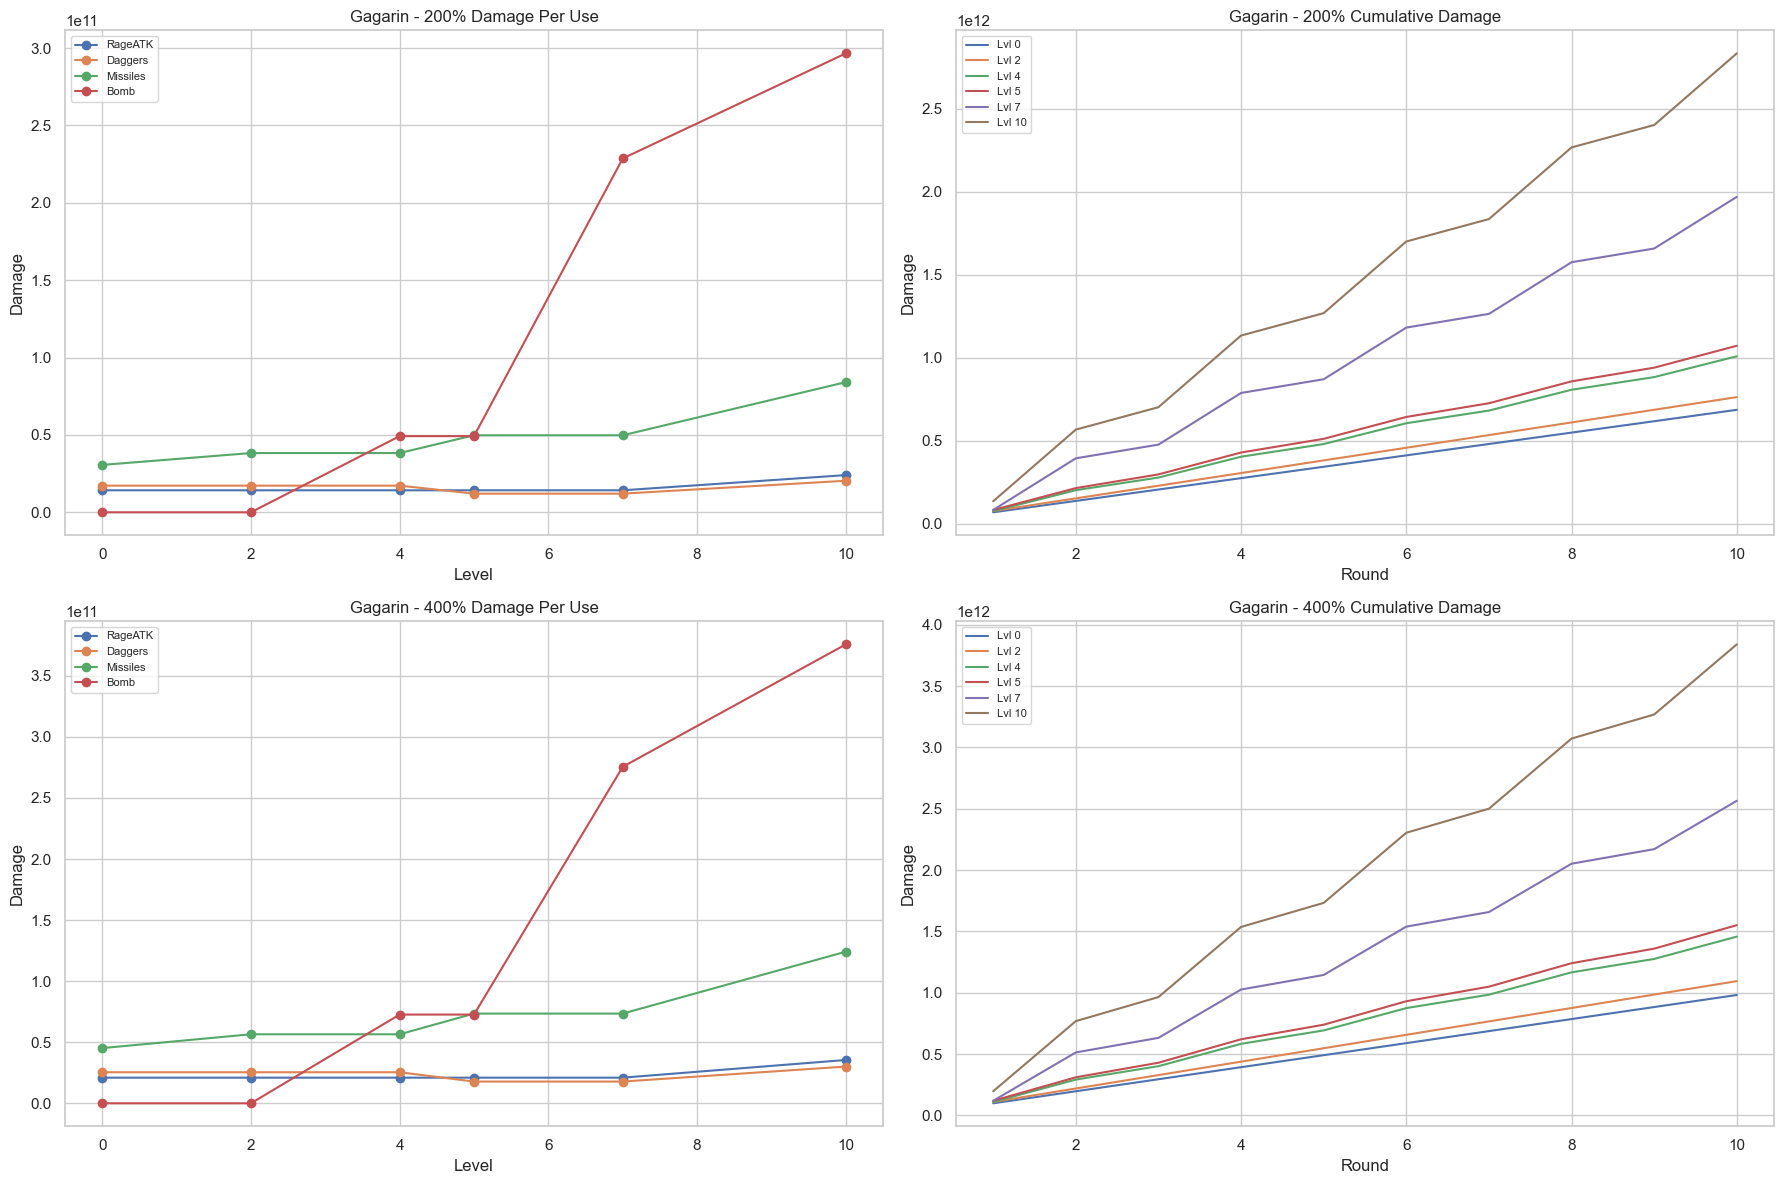

In [ ]:
import matplotlib.pyplot as plt

# === FIGURE 1: GAGARIN ===
fig1, axes1 = plt.subplots(2, 2, figsize=(18, 12))

for i, scenario in enumerate(["200%", "400%"]):
    row = i
    df_gaga = df_all_skills[(df_all_skills["Source"] == "Gagarin") & (df_all_skills["Scenario"] == scenario)]
    df_gaga_r = df_all_rounds[(df_all_rounds["Source"] == "Gagarin") & (df_all_rounds["Scenario"] == scenario)]

    df_gaga.plot(x="Level", y=["RageATK", "Daggers", "Missiles", "Bomb"],
                 ax=axes1[row][0], marker='o',
                 title=f"Gagarin - {scenario} Damage Per Use")

    for lvl in df_gaga_r["Level"].unique():
        sub = df_gaga_r[df_gaga_r["Level"] == lvl]
        axes1[row][1].plot(sub["Round"], sub["TotalDamage"], label=f"Lvl {lvl}")
    axes1[row][1].set_title(f"Gagarin - {scenario} Cumulative Damage")

for ax in axes1.flat:
    ax.set_xlabel("Level" if ax in [axes1[i][0] for i in range(2)] else "Round")
    ax.set_ylabel("Damage")
    ax.grid(True)
    ax.legend(fontsize=8)

plt.tight_layout()
plt.show()


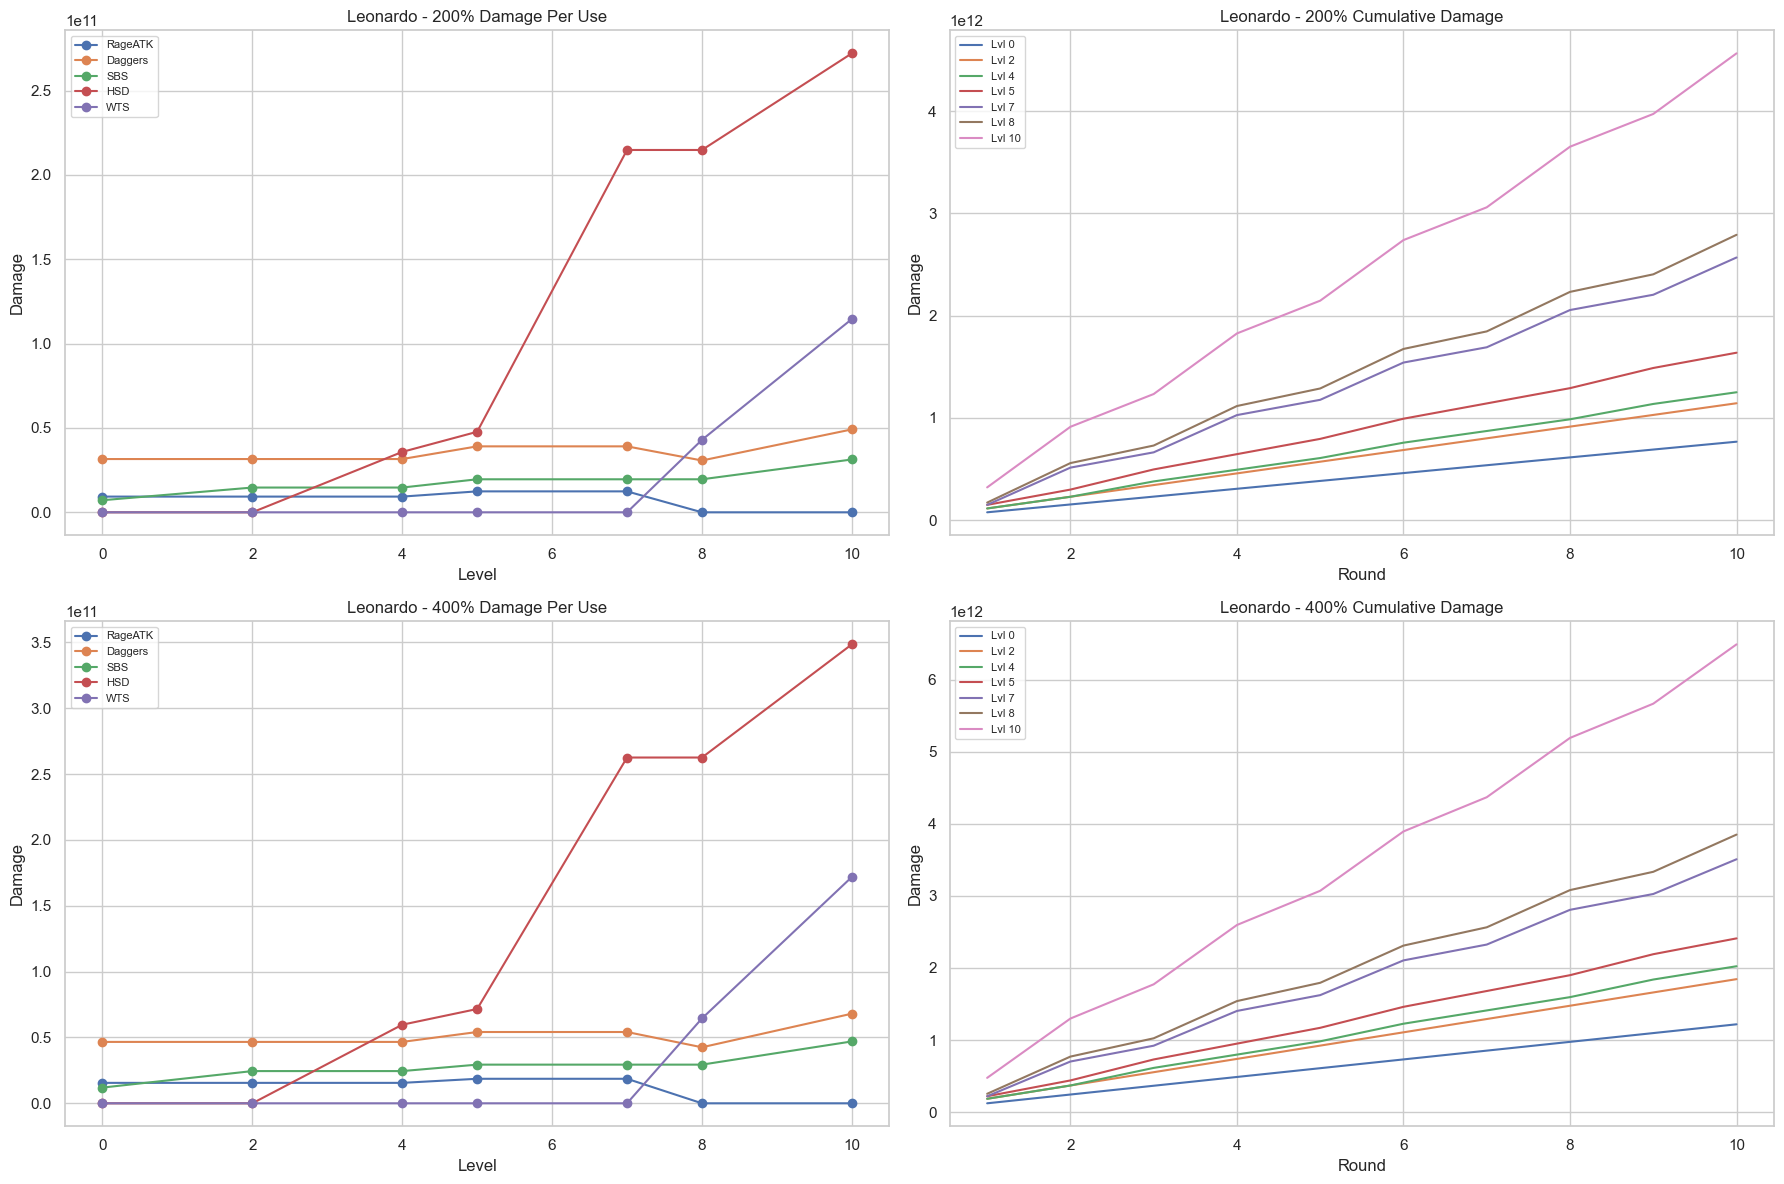

In [ ]:
# === FIGURE 2: LEONARDO ===
fig2, axes2 = plt.subplots(2, 2, figsize=(18, 12))

for i, scenario in enumerate(["200%", "400%"]):
    row = i
    df_leo = df_all_skills[(df_all_skills["Source"] == "Leonardo") & (df_all_skills["Scenario"] == scenario)]
    df_leo_r = df_all_rounds[(df_all_rounds["Source"] == "Leonardo") & (df_all_rounds["Scenario"] == scenario)]

    df_leo.plot(x="Level", y=["RageATK", "Daggers", "SBS", "HSD", "WTS"],
                ax=axes2[row][0], marker='o',
                title=f"Leonardo - {scenario} Damage Per Use")

    for lvl in df_leo_r["Level"].unique():
        sub = df_leo_r[df_leo_r["Level"] == lvl]
        axes2[row][1].plot(sub["Round"], sub["TotalDamage"], label=f"Lvl {lvl}")
    axes2[row][1].set_title(f"Leonardo - {scenario} Cumulative Damage")

for ax in axes2.flat:
    ax.set_xlabel("Level" if ax in [axes2[i][0] for i in range(2)] else "Round")
    ax.set_ylabel("Damage")
    ax.grid(True)
    ax.legend(fontsize=8)

plt.tight_layout()
plt.show()


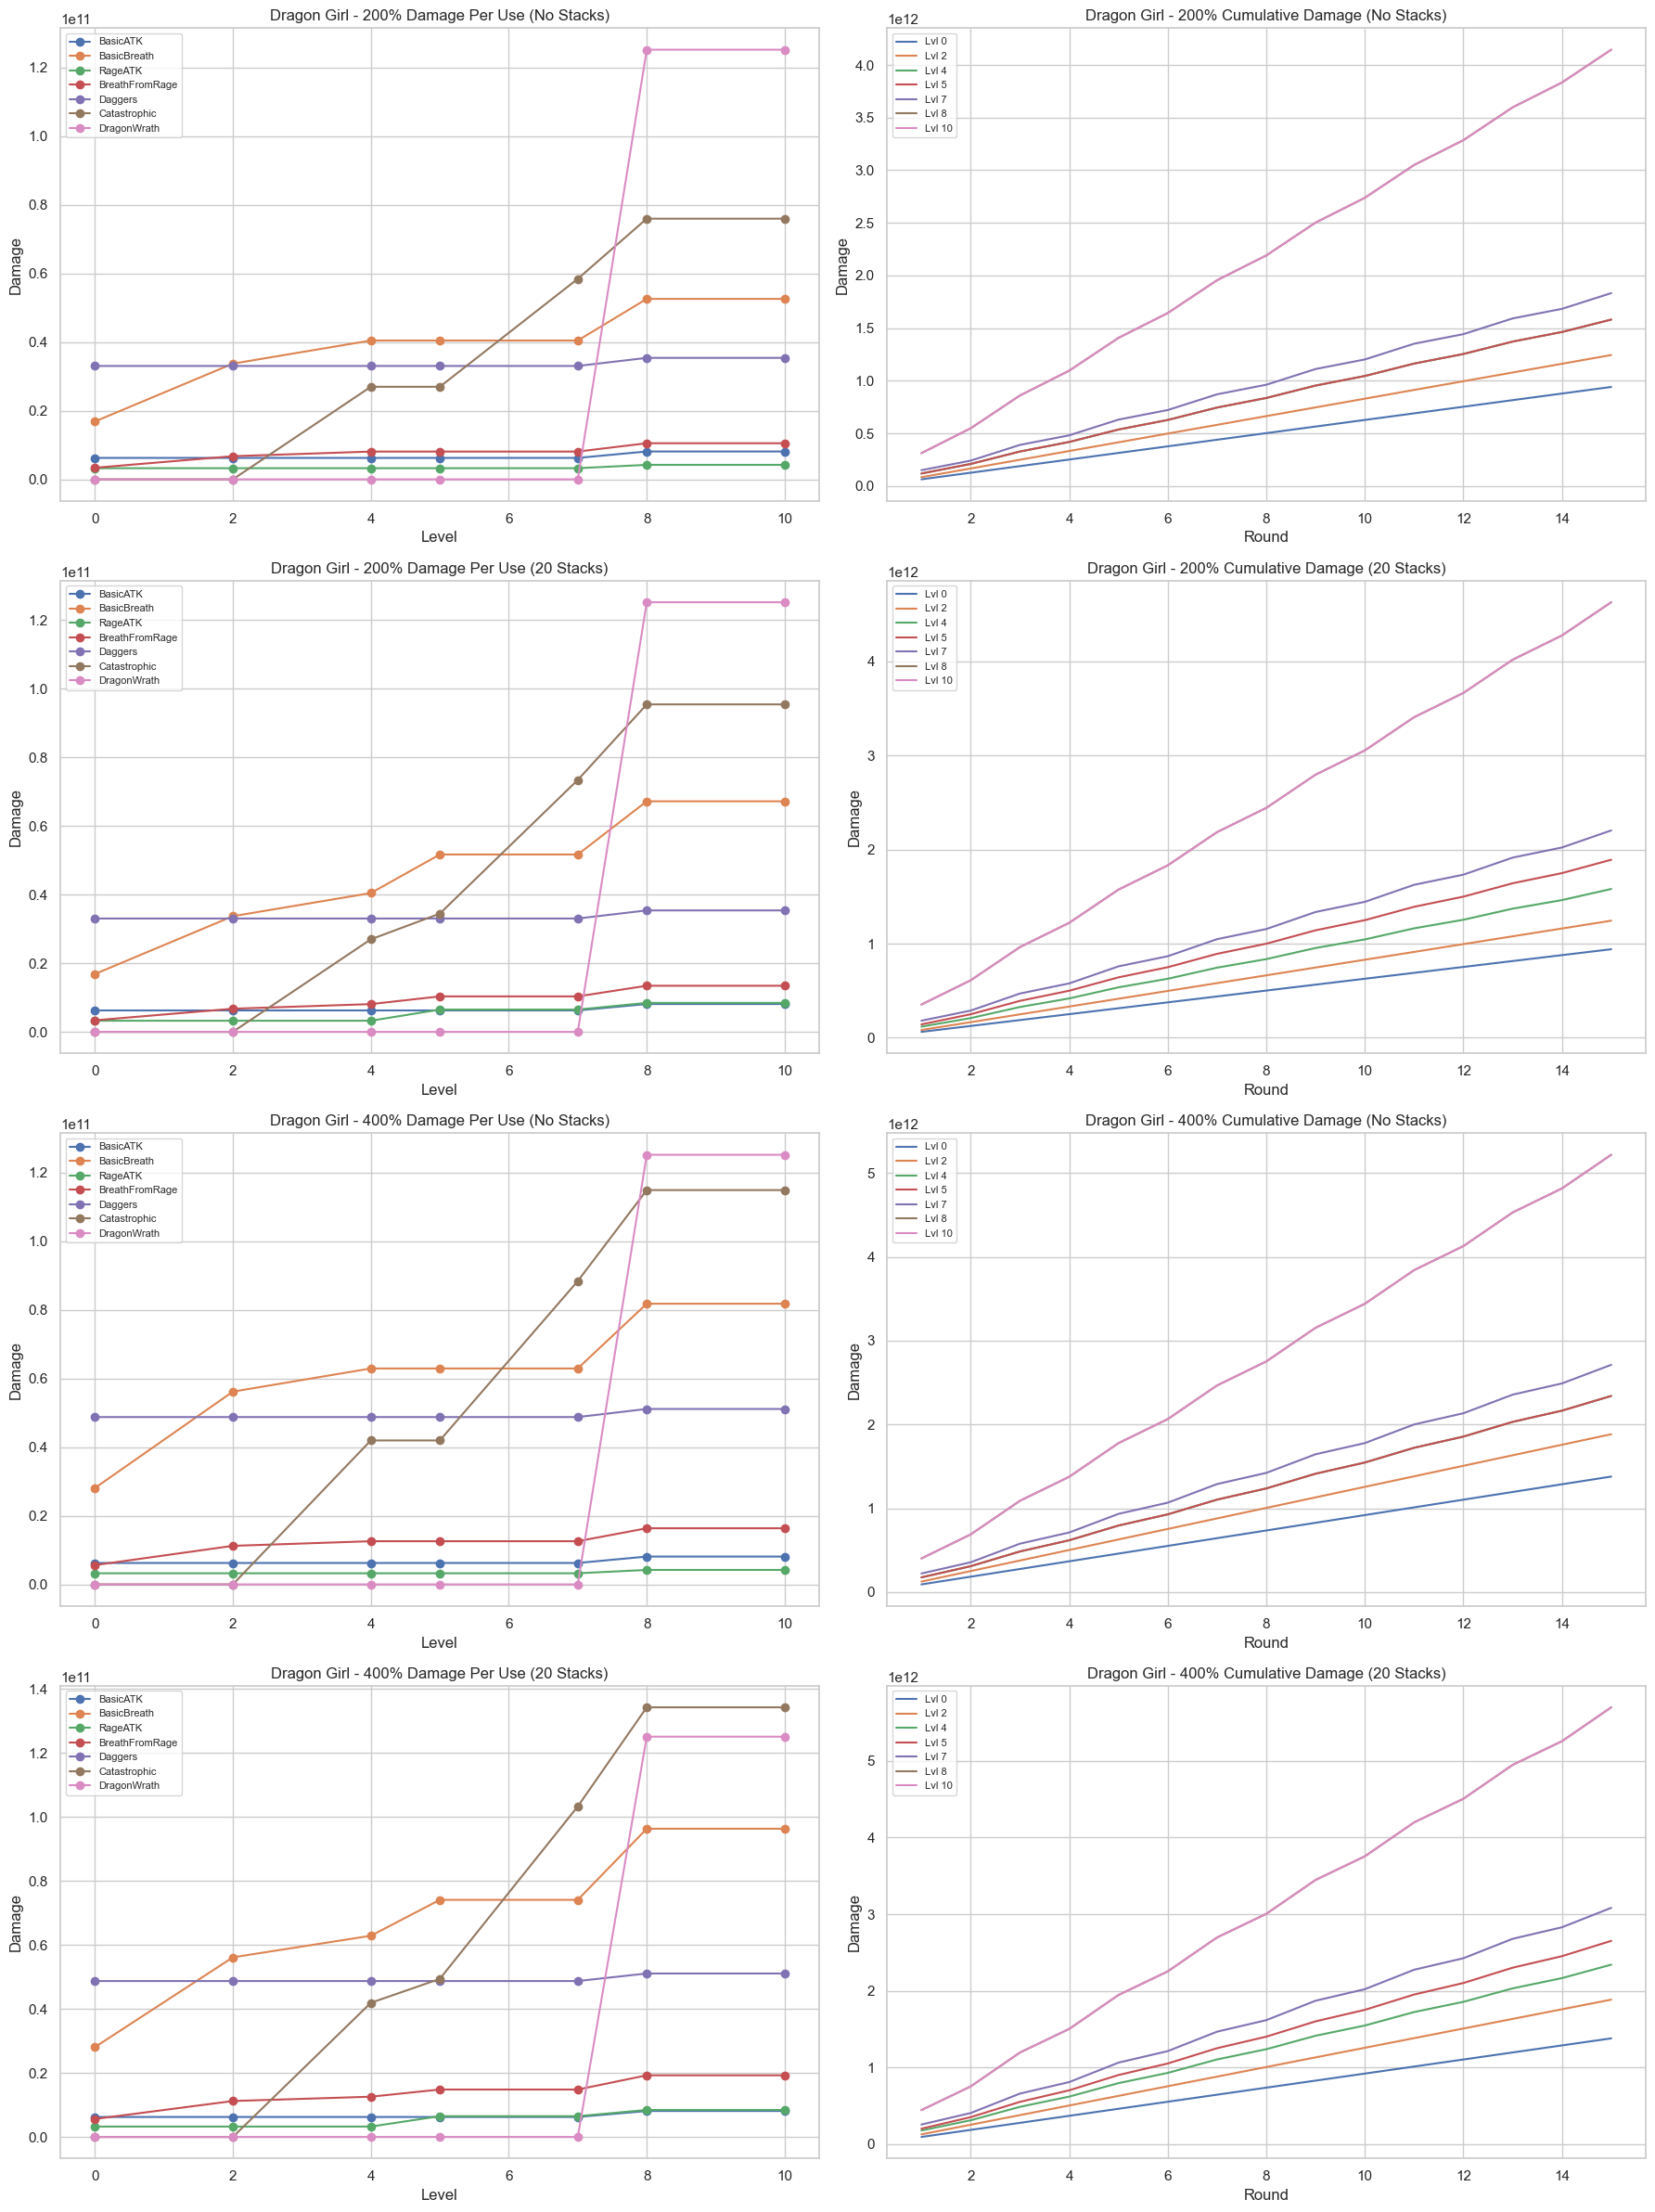

In [ ]:
# === FIGURE 3: DRAGON GIRL (4 rows x 2 columns) ===
fig3, axes3 = plt.subplots(4, 2, figsize=(18, 24))

row = 0
for scenario in ["200%", "400%"]:
    for stacks in ["No Stacks", "20 Stacks"]:
        df_dg = df_all_skills[
            (df_all_skills["Source"] == "Dragon Girl")
            & (df_all_skills["Scenario"] == scenario)
            & (df_all_skills["Stacks"] == stacks)
        ]
        df_dg_r = df_all_rounds[
            (df_all_rounds["Source"] == "Dragon Girl")
            & (df_all_rounds["Scenario"] == scenario)
            & (df_all_rounds["Stacks"] == stacks)
        ]

        # Left plot: Damage per Use
        df_dg.plot(
            x="Level",
            y=["BasicATK", "BasicBreath", "RageATK", "BreathFromRage", "Daggers", "Catastrophic", "DragonWrath"],
            ax=axes3[row][0],
            marker='o',
            title=f"Dragon Girl - {scenario} Damage Per Use ({stacks})"
        )

        # Right plot: Cumulative Damage
        for lvl in df_dg_r["Level"].unique():
            sub = df_dg_r[df_dg_r["Level"] == lvl]
            axes3[row][1].plot(sub["Round"], sub["TotalDamage"], label=f"Lvl {lvl}")
        axes3[row][1].set_title(f"Dragon Girl - {scenario} Cumulative Damage ({stacks})")

        row += 1

# Final formatting
for ax in axes3.flat:
    ax.set_xlabel("Level" if ax in [axes3[i][0] for i in range(4)] else "Round")
    ax.set_ylabel("Damage")
    ax.grid(True)
    ax.legend(fontsize=8)

plt.tight_layout()
plt.show()


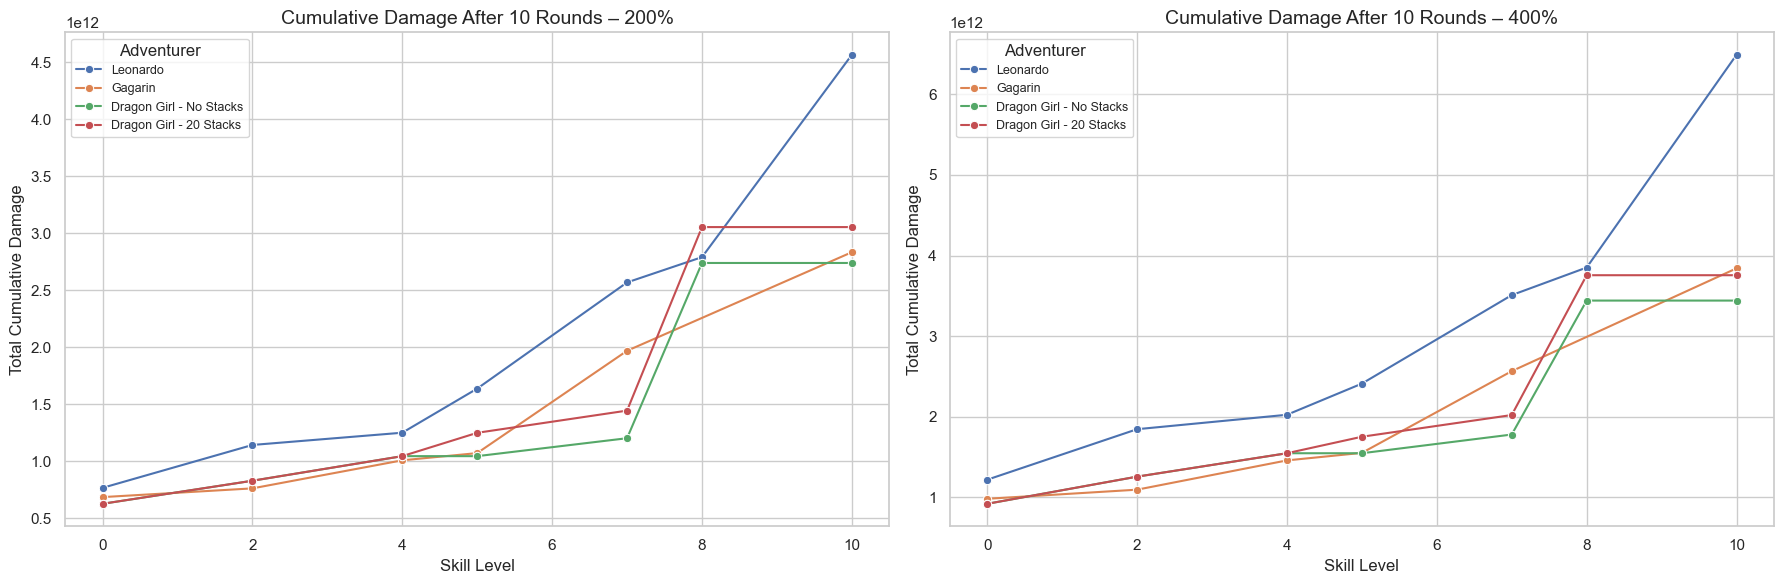

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Extract final round (Round 10) for everyone
df_final_round = df_all_rounds[df_all_rounds["Round"] == 10].copy()

# Step 2: Add "StacksLabel" to distinguish Dragon Girl’s two modes
df_final_round["StacksLabel"] = ""
dg_mask = df_final_round["Source"] == "Dragon Girl"
df_final_round.loc[dg_mask, "StacksLabel"] = " - " + df_final_round.loc[dg_mask, "Stacks"]

# Step 3: Create display-friendly label: "Source (Stacks)"
df_final_round["Label"] = df_final_round["Source"] + df_final_round["StacksLabel"]

# Step 4: Plot
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
axs = axs.flatten()

for i, scenario in enumerate(df_final_round["Scenario"].unique()):
    df_scenario = df_final_round[df_final_round["Scenario"] == scenario]
    ax = axs[i]

    sns.lineplot(
        data=df_scenario,
        x="Level",
        y="TotalDamage",
        hue="Label",
        marker="o",
        ax=ax
    )

    ax.set_title(f"Cumulative Damage After 10 Rounds – {scenario}", fontsize=14)
    ax.set_ylabel("Total Cumulative Damage")
    ax.set_xlabel("Skill Level")
    ax.legend(title="Adventurer", fontsize=9)
    ax.grid(True)

plt.tight_layout()
plt.show()


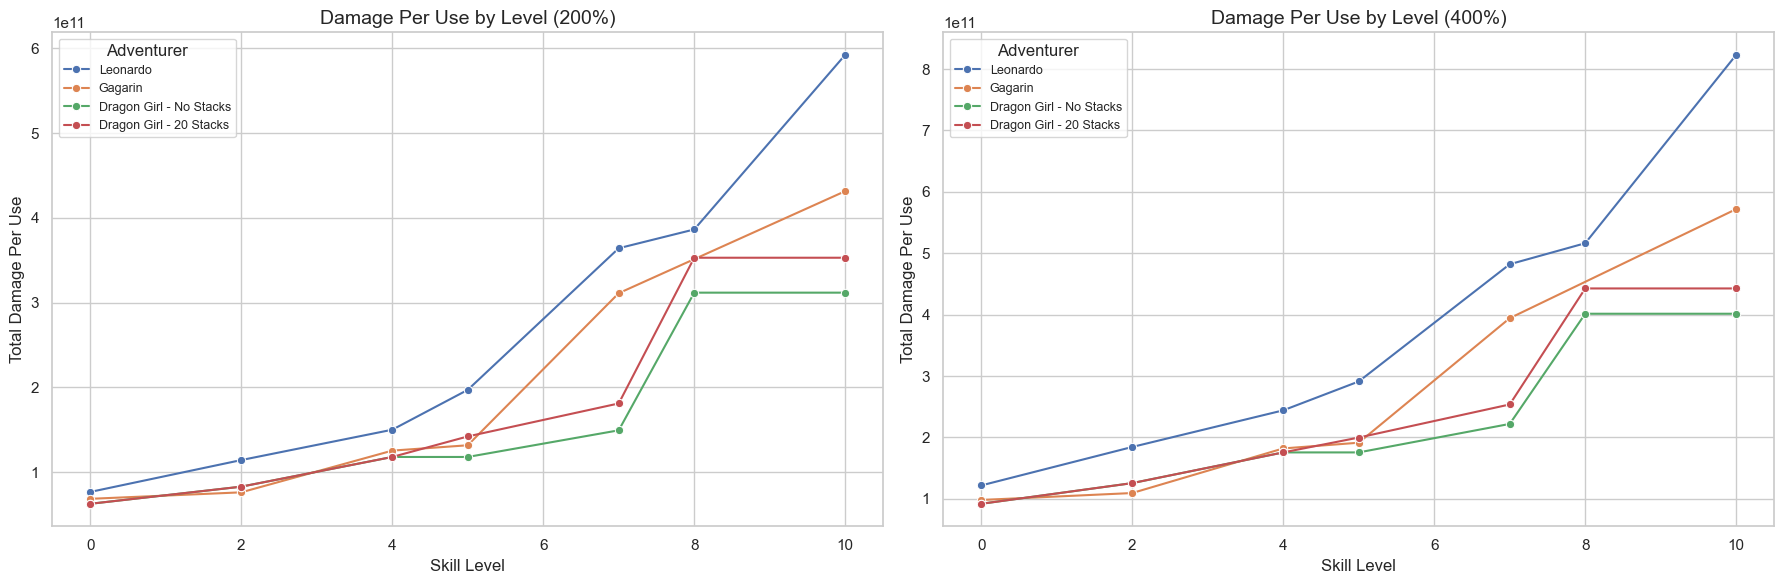

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure numeric types for plotting
df_all_skills["DamagePerUse"] = pd.to_numeric(df_all_skills["Total"], errors="coerce")

# Add "StacksLabel" to distinguish Dragon Girl variants
df_all_skills["StacksLabel"] = ""
dg_mask = df_all_skills["Source"] == "Dragon Girl"
if "Stacks" in df_all_skills.columns:
    df_all_skills.loc[dg_mask, "StacksLabel"] = " - " + df_all_skills.loc[dg_mask, "Stacks"]

# Create display name for the legend
df_all_skills["Label"] = df_all_skills["Source"] + df_all_skills["StacksLabel"]

# Setup plot aesthetics
sns.set(style="whitegrid")
scenarios = df_all_skills["Scenario"].unique()

# Create subplots for each scenario (e.g., 200%, 400%)
fig, axs = plt.subplots(nrows=1, ncols=len(scenarios), figsize=(18, 6))
axs = axs.flatten()

for i, scenario in enumerate(scenarios):
    ax = axs[i]
    df_scenario = df_all_skills[df_all_skills["Scenario"] == scenario]

    sns.lineplot(
        data=df_scenario,
        x="Level",
        y="DamagePerUse",
        hue="Label",
        marker="o",
        ax=ax
    )

    ax.set_title(f"Damage Per Use by Level ({scenario})", fontsize=14)
    ax.set_ylabel("Total Damage Per Use")
    ax.set_xlabel("Skill Level")
    ax.grid(True)
    ax.legend(title="Adventurer", fontsize=9)

plt.tight_layout()
plt.show()


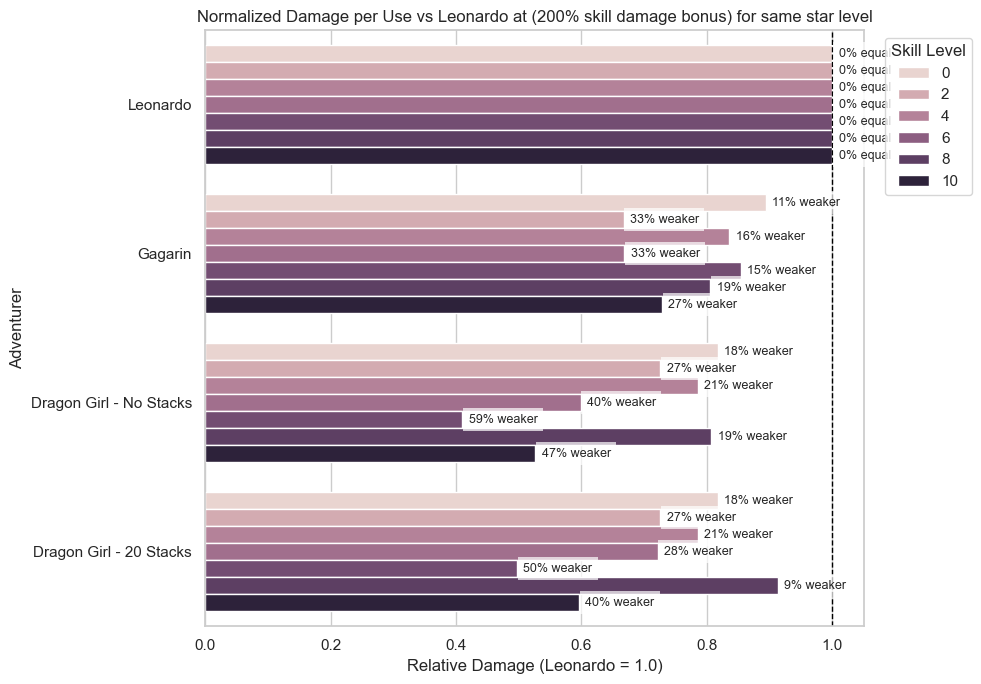

In [ ]:
# Filter Gagarin level 7 data
gaga_lvl7 = df_all_skills[
    (df_all_skills["Source"] == "Gagarin") &
    (df_all_skills["Level"] == 7)
].copy()

# Duplicate and update Level to 8
gaga_lvl8 = gaga_lvl7.copy()
gaga_lvl8["Level"] = 8

# Append to main dataframe
df_all_skills = pd.concat([df_all_skills, gaga_lvl8], ignore_index=True)


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure numeric types
df_all_skills["DamagePerUse"] = pd.to_numeric(df_all_skills["Total"], errors="coerce")

# Clean adventurer label
df_all_skills["StacksLabel"] = ""
if "Stacks" in df_all_skills.columns:
    dg_mask = df_all_skills["Source"] == "Dragon Girl"
    df_all_skills.loc[dg_mask, "StacksLabel"] = " - " + df_all_skills.loc[dg_mask, "Stacks"]

df_all_skills["Label"] = df_all_skills["Source"] + df_all_skills["StacksLabel"]

# Compute baseline (Leonardo's damage) for each level + scenario
baseline = df_all_skills[df_all_skills["Source"] == "Leonardo"][["Scenario", "Level", "DamagePerUse"]]
baseline = baseline.rename(columns={"DamagePerUse": "LeonardoDamage"})

# Join to get Leonardo's damage per row
df_norm = df_all_skills.merge(baseline, on=["Scenario", "Level"], how="left")

# Compute normalized damage as a percentage of Leonardo's
df_norm["Normalized"] = df_norm["DamagePerUse"] / df_norm["LeonardoDamage"]

# Plot setup
plt.figure(figsize=(10, 7))
sns.set(style="whitegrid")

# Filter a single scenario for 200% skill damage bonus
df_plot = df_norm[df_norm["Scenario"] == "200%"]

# Horizontal bar plot
ax = sns.barplot(
    data=df_plot,
    y="Label",
    x="Normalized",
    hue="Level",
    orient="h",
    dodge=True
)

# Draw vertical baseline at 1.0 (Leonardo)
ax.axvline(1.0, color="black", linestyle="--", linewidth=1)

# Add annotations on bars with better text placement and background
for container in ax.containers:
    for bar in container:
        width = bar.get_width()
        diff_pct = (width - 1) * 100
        label = f"{abs(diff_pct):.0f}% {'stronger' if diff_pct > 0 else 'weaker' if diff_pct < 0 else 'equal'}"

        text_y = bar.get_y() + bar.get_height() / 2
        text_x = width + 0.01 if width > 0 else width - 0.01

        ax.text(
            text_x,
            text_y,
            label,
            va="center",
            ha="left" if width > 0 else "right",
            fontsize=9,
            bbox=dict(facecolor='white', edgecolor='none', alpha=0.7)
        )

ax.set_title("Normalized Damage per Use vs Leonardo at (200% skill damage bonus) for same star level")
ax.set_xlabel("Relative Damage (Leonardo = 1.0)")
ax.set_ylabel("Adventurer")
plt.legend(title="Skill Level", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
